# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

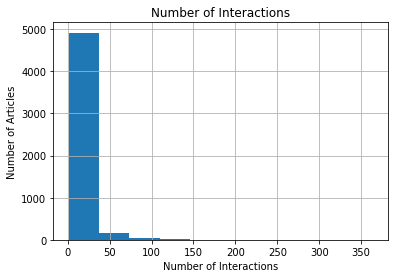

,email
,count
count,5148.000000
mean,8.930847
std,16.802267
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,364.000000


In [3]:
v_userInterationsGroup = df.groupby(['email']).agg({'email': ['count']})

v_userInterationsGroup.hist()
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Articles')
plt.title('Number of Interactions')
plt.show()

display(v_userInterationsGroup.describe())

In [4]:
# Fill in the median and maximum number of user_article interactios below

# 50% of individuals interact with ____ number of articles or fewer.
median_val = v_userInterationsGroup.describe().loc['50%', :].astype(int).values[0]

# The maximum number of user-article interactions by any 1 user is ______.
max_views_by_user = v_userInterationsGroup.describe().loc['max', :].astype(int).values[0]

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [5]:
# Find and explore duplicate articles
v_articles = df_content.groupby('article_id').agg({'article_id': ['count']})
v_articles.columns = [item[1] for item in v_articles.columns] 
v_duplicates = sorted(v_articles[v_articles['count'] != 1].index.tolist())
print(f"Initial number of articles: {df_content.shape[0]}.")
print(f"Article_id for duplicate articles: {v_duplicates}.")

Initial number of articles: 1056.
Article_id for duplicate articles: [50, 221, 232, 398, 577].


In [6]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset=['article_id'], keep = 'first')
print(f"Number of articles after dropping duplicates: {df_content.shape[0]}.")
display(df_content[df_content['article_id'].isin(v_duplicates)])

Number of articles after dropping duplicates: 1051.


,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [7]:
# The number of unique articles that have at least one interaction
unique_articles = df['article_id'].value_counts().shape[0]

# The number of unique articles on the IBM platform
total_articles = v_articles.shape[0]

# The number of unique users
unique_users = df['email'].value_counts().shape[0]

# The number of user-article interactions
user_article_interactions = df.shape[0]

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [8]:
v_userInterationsGroup = df.groupby(['article_id']).agg({'article_id': ['count']})
v_userInterationsGroup.columns = ['Number of Interactions']
v_userInterationsGroup.sort_values('Number of Interactions', ascending = False, inplace = True)

In [9]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = v_userInterationsGroup.reset_index().iloc[0, 0].astype(str)

# The most viewed article in the dataset was viewed how many times?
max_views = v_userInterationsGroup.iloc[0, 0]

In [10]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [11]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [12]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df.groupby(['article_id', 'title']).agg({'article_id': ['count']})
    top_articles.columns = ['Number of Interactions']  
    top_articles = top_articles.sort_values('Number of Interactions', ascending = False).head(n)
    top_articles = top_articles.reset_index()['title']
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    top_articles = df.groupby(['article_id']).agg({'article_id': ['count']})
    top_articles.columns = ['Number of Interactions']    
    top_articles = top_articles.sort_values('Number of Interactions', ascending = False).head(n).index.astype(str).tolist()
 
    return top_articles # Return the top article ids

In [13]:
print(get_top_articles(10))
print(get_top_article_ids(10))

0           use deep learning for image classification
1          insights from new york car accident reports
2                       visualize car data with brunel
3    use xgboost, scikit-learn & ibm watson machine...
4    predicting churn with the spss random tree alg...
5         healthcare python streaming application demo
6    finding optimal locations of new store using d...
7             apache spark lab, part 1: basic concepts
8              analyze energy consumption in buildings
9    gosales transactions for logistic regression m...
Name: title, dtype: object
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [14]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [15]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    
    user_item = df.groupby(['user_id', 'article_id']).count().apply(lambda x: 1, axis = 1).unstack().fillna(0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)
display(user_item.head())

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [17]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''

    most_similar_users = user_item.dot(user_item.T).loc[user_id, :].sort_values(ascending = False).index.tolist()
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [18]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [19]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    df['article_id'] = df['article_id'].astype(str)
    article_names = list(set(df.set_index('article_id').loc[article_ids, 'title'].tolist()))
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    
    v_user_item = user_item.loc[user_id, :]
    
    article_ids = v_user_item[v_user_item == 1].index.tolist()    
    article_ids = [str(item) for item in article_ids]
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m = 10, p_debug = False):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    v_articleRead, _ = get_user_articles(user_id = user_id)
    
    if p_debug: 
        print(f'\nFirst 10 similar users: {find_similar_users(user_id)[:10]}')
    
    v_recs = []
    for similarUser in find_similar_users(user_id = user_id):
        v_articles, _ = get_user_articles(user_id = similarUser)
        v_new_recs    = np.setdiff1d(v_articles, v_articleRead, assume_unique = True)
        if p_debug: 
            print(f'\n*** Similar user {similarUser}.')
            print('Articles (ALL):')
            print(v_articles[:10])
            print('Articles (Recommended):') 
            print(v_new_recs[:m])
        v_recs.extend(list(v_new_recs))
        if len(v_recs) > m: break
    
    if p_debug: 
        print('\n**************************************************************\n')
        print('Articles recommended for user:') 
        print(v_recs[:m])
        
    return v_recs[:m] # return your recommendations for this user_id

In [20]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['timeseries data analysis of iot events by using jupyter notebook',
 'deep forest: towards an alternative to deep neural networks',
 'using machine learning to predict parking difficulty',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'the 3 kinds of context: machine learning and the art of the frame',
 'higher-order logistic regression for large datasets',
 'this week in data science (april 18, 2017)',
 'experience iot with coursera',
 'using brunel in ipython/jupyter notebooks',
 'graph-based machine learning']

In [21]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [22]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    
    v_user_item = user_item.copy()
    v_articleRead = df.groupby('user_id').agg({'article_id': ['count']}).reset_index()
    v_articleRead.columns = ['user_id', 'Number of Interactions']
                     
    v_neighbors_df = ( pd.DataFrame(v_user_item.dot(v_user_item.T).loc[user_id, :])                                    
                            .drop(user_id, axis = 0)
                            .reset_index() ).merge(v_articleRead, how = 'inner', on = 'user_id' )
    v_neighbors_df.columns = ['neighbor_id', 'similarity', 'num_interactions']
    
    v_neighbors_df.sort_values(['similarity', 'num_interactions'], ascending = [False, False], inplace = True)
    
    return v_neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m = 10, p_debug = False):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    v_articleRead, _   = get_user_articles(user_id = user_id)
    v_similarUsers     = get_top_sorted_users(user_id = user_id)
    
    v_userArticleGroup = df.groupby(['article_id']).agg({'article_id': ['count']})
    v_userArticleGroup.columns = ['Number of Interactions']
    v_userArticleGroup.sort_values('Number of Interactions', ascending = False, inplace = True)    
    v_userArticleGroup.reset_index(inplace = True)
    
    if p_debug: 
        print('\nSimilar users:')
        display(v_similarUsers.head(10))
    
    v_recs = []
    for idx in range(v_similarUsers.shape[0]):
        v_similarUser = v_similarUsers.iloc[idx, 0]
        v_articles, _ = get_user_articles(user_id = v_similarUser)
        v_articles    = v_userArticleGroup[v_userArticleGroup['article_id'].isin(v_articles)]['article_id'].astype(str).tolist()
        v_new_recs    = np.setdiff1d(v_articles, v_articleRead, assume_unique = True)        
        if p_debug: 
            print(f'\n*** Similar user {v_similarUser}.')
            print('Articles (ALL):')
            print(v_articles[:10])
            print('Articles (Recommended):') 
            print(v_new_recs[:m])
        v_recs.extend(list(v_new_recs))        
        if len(v_recs) > m: break
    
    if p_debug: 
        print('\n**************************************************************\n')
        print('Articles recommended for user:') 
        print(v_recs[:m])
    
    v_recs = v_recs[:m]
    
    return v_recs, get_article_names(v_recs)

In [23]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1427.0', '1364.0', '1170.0', '1162.0', '1304.0', '1351.0', '1160.0', '1354.0', '1368.0']

The top 10 recommendations for user 20 are the following article names:
['apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'model bike sharing data with spss', 'movie recommender system with spark machine learning', 'putting a human face on machine learning', 'gosales transactions for logistic regression model', 'analyze accident reports on amazon emr spark', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'insights from new york car accident reports', 'analyze energy consumption in buildings']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [24]:
### Tests with a dictionary of results

user1_most_sim   = get_top_sorted_users(1).iloc[0, 0]# Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[9, 0] # Find the 10th most similar user to user 131

In [25]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**The function that we can use for a new user is << get_top_article_ids >>, as we need to implement the rank based recommendations. **

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [26]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10) # Your recommendations here

In [27]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [28]:
from NLPDocument import NLPDocument
from Recommend import RecommendArticles
from Recommend import getUserArticlesMatrix as utl_getUserArticlesMatrix
from Recommend import getArticleSimilarity  as utl_getArticleSimilarity

v_userArticles = df.copy()
v_articles = df_content.copy()

# Create dummy record for empty user
v_userArticles = v_userArticles.append(pd.DataFrame({ 'user_id':    -999, 
                                                      'article_id': -999 }, index = [-1]), ignore_index = True, sort = True)

# Transform the article_id to integer
v_userArticles['article_id'] = v_userArticles['article_id'].apply(lambda x: str(x).split('.')[0]).astype(int)

# Create a list with unique combinations article_id / title based on the interactions dataframe
v_userArticlesGroup = v_userArticles.groupby(['article_id', 'title']).count().reset_index().drop('user_id', axis = 1)

v_userArticles.drop('title', axis = 1, inplace = True)

# Transform the article_id to integer
v_articles['article_id'] = v_articles['article_id'].apply(lambda x: str(x).split('.')[0]).astype(int)

# Create the complete list of articles based on the articles that have a content or only an interaction
v_articles = v_articles.merge(v_userArticlesGroup, how = 'outer', on = 'article_id')

# Create a new column to hold the keywords
v_articles['topic_keywords'] = 'nan'

# Create the keywords based on the fields doc_description / title / doc_full_name (in this order)
for field in ['doc_description', 'title', 'doc_full_name']:
    v_articles[field] = v_articles[field].fillna('nan').apply(lambda x: x.replace('_', ' ').replace('-', ' '))
    for idx in v_articles.index.tolist():
        try:
            if ( v_articles.loc[idx, 'topic_keywords'] == 'nan'
                 and v_articles.loc[idx, field] != 'nan' ):
                v_content = NLPDocument( p_document         = v_articles.loc[idx, field], 
                                         p_usePorterStemmer = True,
                                         p_filterMinSize    = 3,
                                         p_excludeTags      = None ).getTokenizedDoc()
                v_articles.loc[idx, 'topic_keywords'] = v_content
        except Exception as err:
            print(err)
            display(v_articles.loc[idx, :])
            raise 

print('Show the first records from the articles dataframe:')
display(v_articles.head(3))

print('Show the first records from the interactions dataframe:')
display(v_userArticles.head(3))

Show the first records from the articles dataframe:


,doc_body,doc_description,doc_full_name,doc_status,article_id,title,topic_keywords
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0,detect malfunctioning iot sensors with streami...,detect bad read real time use python stream an...
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1,nan,see forest see tree lie challeng perform prese...
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2,"this week in data science (april 18, 2017)",week news data scienc big data


Show the first records from the interactions dataframe:


,article_id,user_id
0,1430,1
1,1314,2
2,1429,3


---
Create a dataframe that holds the similarities between the articles based on the keywords calculated above.

In [29]:
v_articleSimilarity = utl_getArticleSimilarity(v_articles)    
display(v_articleSimilarity.head(3))

article_id,0,1,2,3,4,5,6,7,8,9,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
article_id,,,,,,,,,,,,,,,,,,,,,
0,9,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,18,1,2,1,1,1,2,5,2,...,0,1,0,1,0,1,1,0,0,0
2,0,1,5,1,1,1,0,1,2,2,...,0,0,0,0,0,1,1,0,0,0


----
Create a dataframe that holds the users / articles matrix in which we can identify which user has read which article.

In [30]:
v_userArticlesMatrix = utl_getUserArticlesMatrix(v_userArticles)
display(v_userArticlesMatrix.head(3))

article_id,-999,0,2,4,8,9,12,14,15,16,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
-999,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

---
We make the distinction between 3 cases:
   - **Case 1**: the given user has other similar users with at least 3 common articles
   - **Case 2**: the given user has read at least one article
   - **Case 3**: none of the above
---   
The content based recommendation system contains the following parts:
   - NLP interpretation of the columns doc_description / title / doc_full_name (in this order)
   - create a recommendation system that uses a combination of the following rules:
       1. based on the above cases calculate the following features:
             - **Keywords Similarity** (**1, 2, 3**) - calculate the number of keywords that are contained by an article, based on a search list provided by the user
             - **User Articles Similarity** (**1**) - number of common articles between 2 similar users
             - **User Articles Read** (**1**) - number of unique articles read by a similar user
             - **User Articles Interactions** (**1**) - total number of interactions for a given user
             - **Article Similarity** (**2**) - number of common words between 2 similar articles
             - **Article Read No** (**1, 2, 3**) - the number of times an article has been read
       2. sort the output using the following order:
             - Keywords Similarity
             - User Articles Similarity
             - User Articles Read
             - Article Similarity
             - Article Read No
             - User Articles Interactions

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

---
Make recommendations for a brand new user.

In [31]:
print('Make recommendations for a brand new user without keywords.')
v_rec = RecommendArticles( p_user_id              = -999, 
                           p_articles             = v_articles, 
                           p_userArticles         = v_userArticles,
                           p_userArticlesMatrix   = v_userArticlesMatrix,
                           p_articleSimilarity    = v_articleSimilarity,
                           p_top                  = 10 )
display(v_rec.getRecommendationsDetails())

print('Make recommendations for a brand new user with keywords.')
v_rec = RecommendArticles( p_user_id              = -999, 
                           p_articles             = v_articles, 
                           p_userArticles         = v_userArticles,
                           p_userArticlesMatrix   = v_userArticlesMatrix,
                           p_articleSimilarity    = v_articleSimilarity,
                           p_top                  = 10,
                           p_keywords             = ['learn', 'detect', 'forest'] )
display(v_rec.getRecommendationsDetails())

Make recommendations for a brand new user without keywords.


,article_id,title,topic_keywords,Keywords Similarity,Article Similarity,Article Similar ID,Article Read No,User ID,User Articles Similarity,User Articles Read,User Articles Interactions
0,1429,use deep learning for image classification,deep learn imag classif,0,NaN,NaN,937,NaN,NaN,NaN,NaN
1,1330,insights from new york car accident reports,insight york car accid report,0,NaN,NaN,927,NaN,NaN,NaN,NaN
2,1431,visualize car data with brunel,visual car data brunel,0,NaN,NaN,671,NaN,NaN,NaN,NaN
3,1427,"use xgboost, scikit learn & ibm watson machine...",xgboost scikit learn ibm watson machin learn api,0,NaN,NaN,643,NaN,NaN,NaN,NaN
4,1364,predicting churn with the spss random tree alg...,predict churn spss random tree algorithm,0,NaN,NaN,627,NaN,NaN,NaN,NaN
5,1314,healthcare python streaming application demo,healthcar python stream applic demo,0,NaN,NaN,614,NaN,NaN,NaN,NaN
6,1293,finding optimal locations of new store using d...,find optim locat store use decis optim,0,NaN,NaN,572,NaN,NaN,NaN,NaN
7,1170,"apache spark lab, part 1: basic concepts",apach spark lab part basic concept,0,NaN,NaN,565,NaN,NaN,NaN,NaN
8,1162,analyze energy consumption in buildings,analyz energi consumpt build,0,NaN,NaN,512,NaN,NaN,NaN,NaN
9,1304,gosales transactions for logistic regression m...,gosal transact logist regress model,0,NaN,NaN,483,NaN,NaN,NaN,NaN


Make recommendations for a brand new user with keywords.


,article_id,title,topic_keywords,Keywords Similarity,Article Similarity,Article Similar ID,Article Read No,User ID,User Articles Similarity,User Articles Read,User Articles Interactions
0,871,overfitting in machine learning: what it is an...,overfit machin learn singl handedli ruin model...,2,NaN,NaN,38,NaN,NaN,NaN,NaN
1,905,the random forest algorithm,random forest flexibl easi machin learn algori...,2,NaN,NaN,24,NaN,NaN,NaN,NaN
2,1429,use deep learning for image classification,deep learn imag classif,1,NaN,NaN,937,NaN,NaN,NaN,NaN
3,1427,"use xgboost, scikit learn & ibm watson machine...",xgboost scikit learn ibm watson machin learn api,1,NaN,NaN,643,NaN,NaN,NaN,NaN
4,43,deep learning with tensorflow course by big da...,free deep learn tensorflow cours provid solid ...,1,NaN,NaN,460,NaN,NaN,NaN,NaN
5,1185,classify tumors with machine learning,classifi tumor machin learn,1,NaN,NaN,442,NaN,NaN,NaN,NaN
6,1354,movie recommender system with spark machine le...,movi recommend system spark machin learn,1,NaN,NaN,426,NaN,NaN,NaN,NaN
7,1368,putting a human face on machine learning,put human face machin learn,1,NaN,NaN,418,NaN,NaN,NaN,NaN
8,1336,learn basics about notebooks and apache spark,learn basic notebook apach spark,1,NaN,NaN,379,NaN,NaN,NaN,NaN
9,1172,"apache spark lab, part 3: machine learning",apach spark lab part machin learn,1,NaN,NaN,363,NaN,NaN,NaN,NaN


----
Make recommendations for a user who only has interacted with article id '1427.0'

In [32]:
v_data = v_userArticlesMatrix[v_userArticlesMatrix[1427] == 1].sum(axis = 1)
v_data = v_data[v_data == 1].index.tolist()[3]
v_rec = RecommendArticles( p_user_id              = v_data, 
                           p_articles             = v_articles, 
                           p_userArticles         = v_userArticles,
                           p_userArticlesMatrix   = v_userArticlesMatrix,
                           p_articleSimilarity    = v_articleSimilarity,
                           p_top                  = 10 )
display(v_rec.getUser().getUserArticles())
display(v_rec.getRecommendationsDetails())

v_rec = RecommendArticles( p_user_id              = v_data, 
                           p_articles             = v_articles, 
                           p_userArticles         = v_userArticles,
                           p_userArticlesMatrix   = v_userArticlesMatrix,
                           p_articleSimilarity    = v_articleSimilarity,
                           p_top                  = 10,
                           p_keywords             = ['learn', 'detect', 'forest'] )
display(v_rec.getRecommendationsDetails())

,article_id,title,topic_keywords,Article Read No,user_id
0,1427,"use xgboost, scikit learn & ibm watson machine...",xgboost scikit learn ibm watson machin learn api,643,2234


,article_id,title,topic_keywords,Keywords Similarity,Article Similarity,Article Similar ID,Article Read No,User ID,User Articles Similarity,User Articles Read,User Articles Interactions
0,254,"apple, ibm add machine learning to partnership...",appl ibm announc provid way combin ibm watson ...,0,4,1427,59,NaN,NaN,NaN,NaN
1,967,ml algorithm != learning machine,easi build learn machin one hire machin learn ...,0,4,1427,45,NaN,NaN,NaN,NaN
2,686,score a predictive model built with ibm spss m...,watch video see ibm watson machin learn ibm da...,0,4,1427,18,NaN,NaN,NaN,NaN
3,437,ibm watson machine learning: get started,watch video see get start ibm watson machin le...,0,4,1427,10,NaN,NaN,NaN,NaN
4,655,create a project for watson machine learning i...,watch video see creat project ibm data scienc ...,0,4,1427,9,NaN,NaN,NaN,NaN
5,805,machine learning for everyone,today take anoth step toward make machin learn...,0,4,1427,5,NaN,NaN,NaN,NaN
6,662,build deep learning architectures with neural ...,video show build deep learn model use popular ...,0,4,1427,1,NaN,NaN,NaN,NaN
7,260,the machine learning database,mldb open­sourc databas design machin learn se...,0,3,1427,222,NaN,NaN,NaN,NaN
8,482,using deep learning with keras to predict cust...,predict custom churn use deep learn kera produ...,0,3,1427,160,NaN,NaN,NaN,NaN
9,250,building your first machine learning system,part give overview machin learn discuss tool b...,0,3,1427,155,NaN,NaN,NaN,NaN


,article_id,title,topic_keywords,Keywords Similarity,Article Similarity,Article Similar ID,Article Read No,User ID,User Articles Similarity,User Articles Read,User Articles Interactions
0,871,overfitting in machine learning: what it is an...,overfit machin learn singl handedli ruin model...,2,2,1427,38,NaN,NaN,NaN,NaN
1,905,the random forest algorithm,random forest flexibl easi machin learn algori...,2,2,1427,24,NaN,NaN,NaN,NaN
2,254,"apple, ibm add machine learning to partnership...",appl ibm announc provid way combin ibm watson ...,1,4,1427,59,NaN,NaN,NaN,NaN
3,967,ml algorithm != learning machine,easi build learn machin one hire machin learn ...,1,4,1427,45,NaN,NaN,NaN,NaN
4,686,score a predictive model built with ibm spss m...,watch video see ibm watson machin learn ibm da...,1,4,1427,18,NaN,NaN,NaN,NaN
5,437,ibm watson machine learning: get started,watch video see get start ibm watson machin le...,1,4,1427,10,NaN,NaN,NaN,NaN
6,655,create a project for watson machine learning i...,watch video see creat project ibm data scienc ...,1,4,1427,9,NaN,NaN,NaN,NaN
7,805,machine learning for everyone,today take anoth step toward make machin learn...,1,4,1427,5,NaN,NaN,NaN,NaN
8,662,build deep learning architectures with neural ...,video show build deep learn model use popular ...,1,4,1427,1,NaN,NaN,NaN,NaN
9,260,the machine learning database,mldb open­sourc databas design machin learn se...,1,3,1427,222,NaN,NaN,NaN,NaN


----
Make recommendations for a user who only has interacted with article id '1427.0' and another article.

In [33]:
v_data = v_userArticlesMatrix[v_userArticlesMatrix[1427] == 1].sum(axis = 1)
v_data = v_data[v_data == 2].index.tolist()[3]
v_rec = RecommendArticles( p_user_id              = v_data, 
                           p_articles             = v_articles, 
                           p_userArticles         = v_userArticles,
                           p_userArticlesMatrix   = v_userArticlesMatrix,
                           p_articleSimilarity    = v_articleSimilarity,
                           p_top                  = 10 )
display(v_rec.getUser().getUserArticles())
display(v_rec.getRecommendationsDetails())

v_rec = RecommendArticles( p_user_id              = v_data, 
                           p_articles             = v_articles, 
                           p_userArticles         = v_userArticles,
                           p_userArticlesMatrix   = v_userArticlesMatrix,
                           p_articleSimilarity    = v_articleSimilarity,
                           p_top                  = 10,
                           p_keywords             = ['learn', 'detect', 'forest'] )
display(v_rec.getRecommendationsDetails())

,article_id,title,topic_keywords,Article Read No,user_id
0,1427,"use xgboost, scikit learn & ibm watson machine...",xgboost scikit learn ibm watson machin learn api,643,2149
1,482,using deep learning with keras to predict cust...,predict custom churn use deep learn kera produ...,160,2149


,article_id,title,topic_keywords,Keywords Similarity,Article Similarity,Article Similar ID,Article Read No,User ID,User Articles Similarity,User Articles Read,User Articles Interactions
0,254,"apple, ibm add machine learning to partnership...",appl ibm announc provid way combin ibm watson ...,0,4,1427,59,NaN,NaN,NaN,NaN
1,967,ml algorithm != learning machine,easi build learn machin one hire machin learn ...,0,4,1427,45,NaN,NaN,NaN,NaN
2,686,score a predictive model built with ibm spss m...,watch video see ibm watson machin learn ibm da...,0,4,1427,18,NaN,NaN,NaN,NaN
3,437,ibm watson machine learning: get started,watch video see get start ibm watson machin le...,0,4,1427,10,NaN,NaN,NaN,NaN
4,655,create a project for watson machine learning i...,watch video see creat project ibm data scienc ...,0,4,1427,9,NaN,NaN,NaN,NaN
5,805,machine learning for everyone,today take anoth step toward make machin learn...,0,4,1427,5,NaN,NaN,NaN,NaN
6,662,build deep learning architectures with neural ...,video show build deep learn model use popular ...,0,4,1427,1,NaN,NaN,NaN,NaN
7,1427,"use xgboost, scikit learn & ibm watson machine...",xgboost scikit learn ibm watson machin learn api,0,3,482,643,NaN,NaN,NaN,NaN
8,260,the machine learning database,mldb open­sourc databas design machin learn se...,0,3,1427,222,NaN,NaN,NaN,NaN
9,482,using deep learning with keras to predict cust...,predict custom churn use deep learn kera produ...,0,3,1427,160,NaN,NaN,NaN,NaN


,article_id,title,topic_keywords,Keywords Similarity,Article Similarity,Article Similar ID,Article Read No,User ID,User Articles Similarity,User Articles Read,User Articles Interactions
0,871,overfitting in machine learning: what it is an...,overfit machin learn singl handedli ruin model...,2,2,1427,38,NaN,NaN,NaN,NaN
1,905,the random forest algorithm,random forest flexibl easi machin learn algori...,2,2,1427,24,NaN,NaN,NaN,NaN
2,254,"apple, ibm add machine learning to partnership...",appl ibm announc provid way combin ibm watson ...,1,4,1427,59,NaN,NaN,NaN,NaN
3,967,ml algorithm != learning machine,easi build learn machin one hire machin learn ...,1,4,1427,45,NaN,NaN,NaN,NaN
4,686,score a predictive model built with ibm spss m...,watch video see ibm watson machin learn ibm da...,1,4,1427,18,NaN,NaN,NaN,NaN
5,437,ibm watson machine learning: get started,watch video see get start ibm watson machin le...,1,4,1427,10,NaN,NaN,NaN,NaN
6,655,create a project for watson machine learning i...,watch video see creat project ibm data scienc ...,1,4,1427,9,NaN,NaN,NaN,NaN
7,805,machine learning for everyone,today take anoth step toward make machin learn...,1,4,1427,5,NaN,NaN,NaN,NaN
8,662,build deep learning architectures with neural ...,video show build deep learn model use popular ...,1,4,1427,1,NaN,NaN,NaN,NaN
9,1427,"use xgboost, scikit learn & ibm watson machine...",xgboost scikit learn ibm watson machin learn api,1,3,482,643,NaN,NaN,NaN,NaN


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [34]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [35]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [36]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices
print(s.shape, u.shape, vt.shape)

(714,) (5149, 5149) (714, 714)


**The user_item_matrix is created using only two possible values: 0 and 1 (corresponding to the fact that a user has interacted or not with an article). As we always have either value 0 or 1 for all combinations between users and articles, it means that the matrix will not have null values. As we don't have null values, we can apply SVD.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

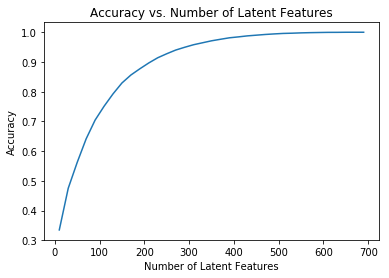

In [37]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many movies can we make predictions for in the test set?  
* How many movies are we not able to make predictions for because of the cold start problem?

In [38]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = df_train.groupby(['user_id', 'article_id']).count().iloc[:, 0].apply(lambda x: 1).unstack().fillna(0)
    user_item_test  = df_test.groupby(['user_id', 'article_id']).count().iloc[:, 0].apply(lambda x: 1).unstack().fillna(0)
    
    test_idx  = user_item_test.index.tolist()
    test_arts = user_item_test.columns.tolist()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [39]:
v_commonUsers    = np.intersect1d(test_idx,  user_item_train.index.tolist())
v_commonArticles = np.intersect1d(test_arts, user_item_train.columns.tolist())  

a = len(test_idx) - len(v_commonUsers)
b = len(v_commonArticles)
c = len(v_commonUsers)
d = len(test_arts) - len(v_commonArticles)

print(a, b, c, d)

662 574 20 0


In [40]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 

sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find **U**, **S**, and **V** transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [41]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below
print(s_train.shape, u_train.shape, vt_train.shape)

(714,) (4487, 4487) (714, 714)


In [42]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

v_userList = np.intersect1d(test_idx, user_item_train.index.tolist()).tolist()

user_train_subset = user_item_train.reset_index()
user_train_subset = user_train_subset[user_train_subset['user_id'].isin(v_userList)].reset_index()

user_test_subset = user_item_test.reset_index()
user_test_subset = user_test_subset[user_test_subset['user_id'].isin(v_userList)].reset_index()

# Get the list of indices in the training matrix
v_userIdx = user_train_subset['index'].tolist()

user_train_subset = user_train_subset.drop(['index', 'user_id'], axis = 1)
user_test_subset  = user_test_subset.drop(['index', 'user_id'], axis = 1)

for item in list(np.setdiff1d( user_train_subset.columns.tolist(), 
                               user_test_subset.columns.tolist(), 
                               assume_unique = True )):
    user_test_subset[item] = 0

user_test_subset = user_test_subset[user_train_subset.columns]

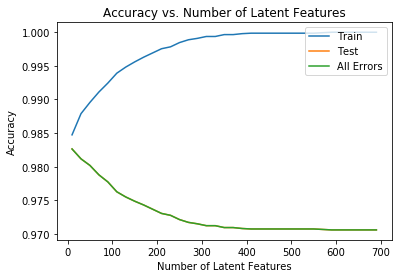

In [46]:
num_latent_feats = np.arange(10, 700 + 10, 20)

sum_acc_train = []
sum_acc_test  = []
sum_acc_all   = []
for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))[v_userIdx]
    
    # compute accuracy for predictions to actual value    
    v_acc_train = np.mean(np.sum(np.array(user_train_subset) == user_item_est, axis = 1) / user_train_subset.shape[1])
    v_acc_test  = np.mean(np.sum(np.array(user_test_subset)  == user_item_est, axis = 1) / user_test_subset.shape[1])
    
    sum_acc_train.append(v_acc_train)
    sum_acc_test.append(v_acc_test)
    sum_acc_all.append(np.min([v_acc_train, v_acc_test]))
    
plt.plot(num_latent_feats, sum_acc_train, label = 'Train');
plt.plot(num_latent_feats, sum_acc_test,  label = 'Test');
plt.plot(num_latent_feats, sum_acc_all,   label = 'All Errors');
plt.legend(loc = 'upper right')
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

One way to handle the scalability and sparsity issue created by Collaborative Filtering is to leverage a latent factor model to capture the similarity between users and items and to reduce the dimensionality.

We can see that the SVD is starting to overfit quite fast and the overall accuracy is quite high for only a reduced number of latent features, and even when starting to overfit the system still has a good overall accuracy.

In order to determine if a new recommandation system is an improvement on how the users currently find articles, we could set up an experiment for a certain period and measure the change in user behavior when interacting with the two different recommendation systems. 

For example, if users of the experimental system follow the recommendations more often, or if some
utility gathered from users of the experimental system exceeds utility gathered from users of the other system, then we can conclude that the new system is superior to the previous recommendation system.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [44]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0